In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from sklearn.model_selection import train_test_split
import gcsfs
from tensorflow.keras.losses import Loss

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/koust_fiminqv/Desktop/thesis/thesis-428619-ddafc8bc8aa4.json'

In [4]:
class IoULoss(Loss):
    def call(self, y_true, y_pred):
        intersection = tf.reduce_sum(tf.minimum(y_true, y_pred), axis=-1)
        union = tf.reduce_sum(tf.maximum(y_true, y_pred), axis=-1)
        iou = intersection / union
        return 1 - iou

In [5]:
def display_image_with_bbox(image, bbox):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[3], bbox[2], 
                                      linewidth=2, edgecolor='r', facecolor='none'))
    plt.axis('off')
    plt.show()

In [6]:
def load_and_preprocess_testimage(path, target_size=(224, 224)):
    fs = gcsfs.GCSFileSystem(project='thesis-428619')
    path = path.replace("gs://", "")
    with fs.open(path, 'rb') as f:
        img_bytes = f.read()
        img = load_img(BytesIO(img_bytes), target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  
        return img, img_array

In [7]:
def convert_to_corners(box):
    xmin, ymax, width, height = box
    xmax = xmin + width
    ymin = ymax - height
    return [xmin, ymin, xmax, ymax]

def calculate_iou(pred_box, true_box):
    pred_box = convert_to_corners(pred_box)
    true_box = convert_to_corners(true_box)
    
    xA = max(pred_box[0], true_box[0])
    yA = max(pred_box[1], true_box[1])
    xB = min(pred_box[2], true_box[2])
    yB = min(pred_box[3], true_box[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    boxBArea = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def evaluate_iou(model, X_test, y_test):
    y_pred = model.predict(X_test)
    ious = []
    for i in range(len(y_test)):
        iou = calculate_iou(y_pred[i], y_test[i])
        ious.append(iou)
    return np.mean(ious)

In [8]:
X_test = np.load('C:/Users/koust_fiminqv/Desktop/thesis/X_test.npy')
y_test = np.load('C:/Users/koust_fiminqv/Desktop/thesis/y_test.npy')

In [9]:
get_custom_objects().update({'IoULoss': IoULoss})
basic_model = load_model('C:/Users/koust_fiminqv/Desktop/thesis/models/basic_model.h5')
tuned_model = load_model('C:/Users/koust_fiminqv/Desktop/thesis/models/tuned_model.h5', custom_objects={'IoULoss': IoULoss})
resnet = load_model('C:/Users/koust_fiminqv/Desktop/thesis/models/resnet_tuned_model.h5', custom_objects={'IoULoss': IoULoss})

In [10]:
result_metrics = pd.DataFrame({
  'basic model' : [round(evaluate_iou(basic_model, X_test, y_test), 2)],
  'tuned model' : [round(evaluate_iou(tuned_model, X_test, y_test), 2)],
  'Resnet model' : [round(evaluate_iou(resnet, X_test, y_test), 2)]
}, index=['IoU'])

6/6 [==============================] - 11s 2s/step


In [11]:
print(result_metrics)

     basic model  tuned model  Resnet model
IoU         0.52         0.55          0.69


In [12]:
test_file = pd.read_csv('C:/Users/koust_fiminqv/Desktop/thesis/csv/test.csv')

In [13]:
file_paths = test_file.path.to_list()

In [14]:
from google.cloud import storage
from urllib.parse import urlparse
def download_and_display_image(bucket_name, file_name, local_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(file_name)
    blob.download_to_filename(local_path)

    image = Image.open(local_path)
    plt.imshow(image)
    plt.axis('off') 
    plt.show()

In [15]:
def download_and_display_image(bucket_name, file_name, local_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(file_name)
    blob.download_to_filename(local_path)

    image = Image.open(local_path)
    return image

In [16]:
def display_image_with_bboxes(image, bboxes, colors, labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    for bbox, color, label in zip(bboxes, colors, labels):
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[3], bbox[2], 
                                          linewidth=2, edgecolor=color, facecolor='none', label=label))
    plt.axis('off')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.show()

In [17]:
bucket_name = "nutritional-table-image-data"

6/6 [==============================] - 11s 2s/step


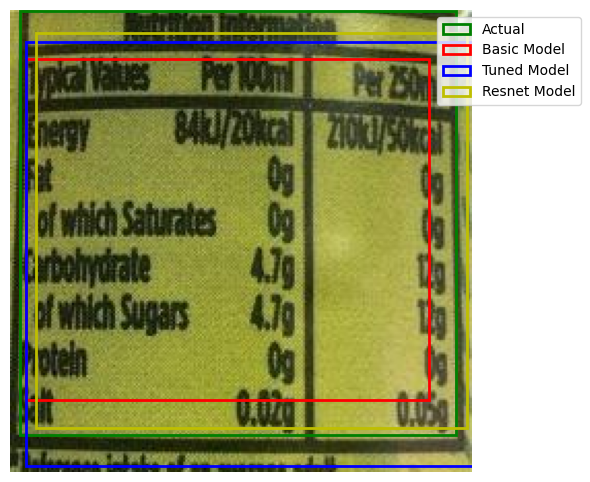

6/6 [==============================] - 11s 2s/step


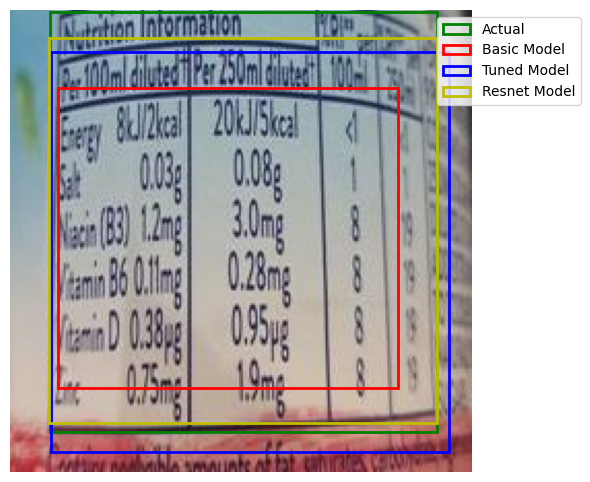

6/6 [==============================] - 10s 2s/step


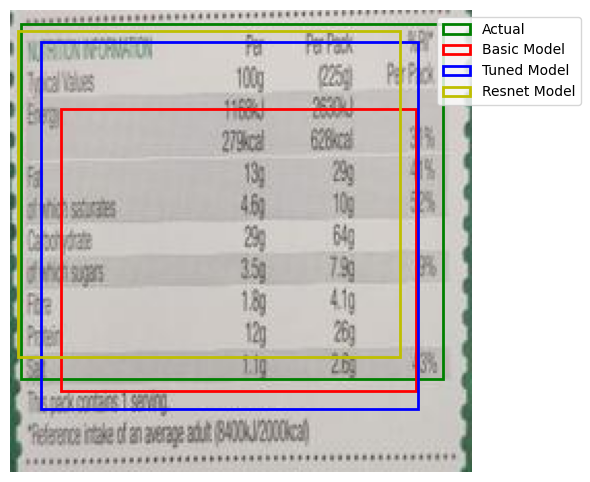

6/6 [==============================] - 10s 2s/step


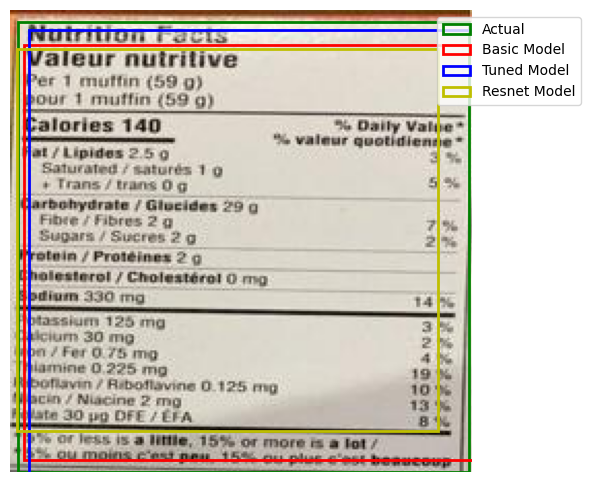

In [18]:
for i in range(4):
    file_name = urlparse(file_paths[i]).path.lstrip('/')
    local_path = f"C:/Users/koust_fiminqv/Desktop/thesis/temp/{file_paths[i].split('/')[-1]}"
    
    image = download_and_display_image(bucket_name, file_name, local_path)
    actual_bbox = y_test[i]
    pred_bbox_basic = basic_model.predict(X_test)[i]
    pred_bbox_tuned = tuned_model.predict(X_test)[i]
    pred_bbox_resnet = resnet.predict(X_test)[i]
    bboxes = [actual_bbox, pred_bbox_basic, pred_bbox_tuned, pred_bbox_resnet]
    colors = ['g', 'r', 'b', 'y']  
    labels = ['Actual', 'Basic Model', 'Tuned Model', 'Resnet Model']
    
    display_image_with_bboxes(image, bboxes, colors, labels)

In [19]:
def load_image(image_path):
    image = Image.open(image_path)
    original_size = image.size
    return image, original_size

In [20]:
def resize_image(image, target_size=(224, 224)):
    image = image.resize(target_size)
    image = np.array(image) / 255.0  
    image = np.expand_dims(image, axis=0)  
    return image

In [21]:
def display_image_with_bboxes(image, bboxes, colors, labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    for bbox, color, label in zip(bboxes, colors, labels):
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                                          linewidth=2, edgecolor=color, facecolor='none', label=label))
    plt.axis('off')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.show()

In [22]:
def map_bboxes_to_original_size(bboxes, original_size, target_size=(224, 224)):
    scale_x = original_size[0] / target_size[0]
    scale_y = original_size[1] / target_size[1]
    original_bboxes = []
    for bbox in bboxes:
        x, y, h, w = bbox
        original_bbox = [x * scale_x, y * scale_y, w * scale_x, h * scale_y]
        original_bboxes.append(original_bbox)
    return original_bboxes

In [23]:
def load_and_resize_image(image_path, target_size=(224, 224)):
    image, original_size = load_image(image_path)
    resized_image = resize_image(image, target_size)
    return resized_image, original_size

In [24]:
images = []
for i in range(4):
    image_path = f'C:/Users/koust_fiminqv/Desktop/thesis/test_image/test{i}.jpg'
    images.append(load_and_resize_image(image_path))

In [25]:
def predict_and_display_bboxes(image_data, models, model_labels, colors):
    image, original_size = image_data
    pred_bboxes = [model.predict(image)[0] for model in models]
    original_bboxes = map_bboxes_to_original_size(pred_bboxes, original_size)
    image_display = np.squeeze(image)
    image_display = (image_display * 255).astype(np.uint8) 
    image_display = Image.fromarray(image_display).resize(original_size)
    
    display_image_with_bboxes(image_display, original_bboxes, colors, model_labels)

models = [basic_model, tuned_model, resnet]
model_labels = ['Basic Model', 'Tuned Model', 'ResNet Model']
colors = ['red', 'green', 'blue']

1/1 [==============================] - 0s 178ms/step


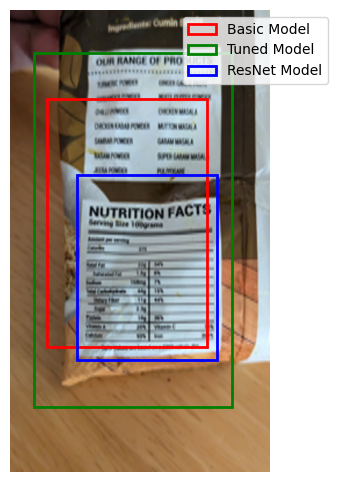

1/1 [==============================] - 0s 184ms/step


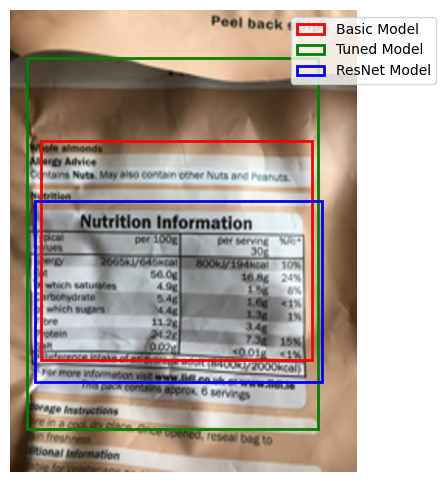

1/1 [==============================] - 0s 177ms/step


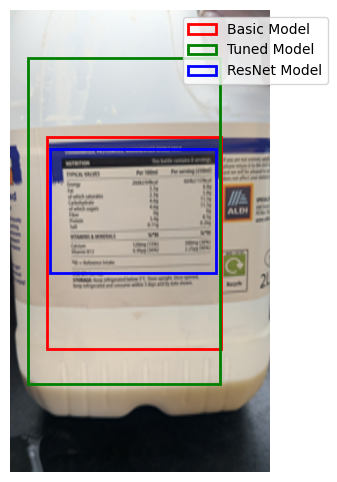

1/1 [==============================] - 0s 179ms/step


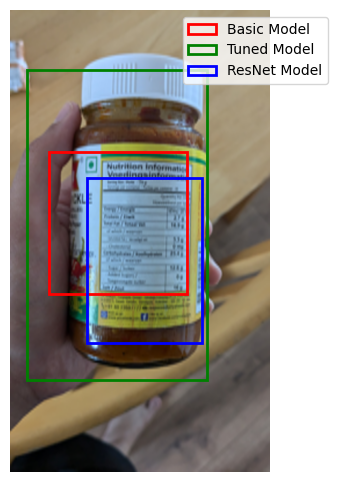

In [26]:
for i in range(4):
  predict_and_display_bboxes(images[i], models, model_labels, colors)

In [27]:
from crop import ImageCropper
image_cropper = ImageCropper(resnet)

In [28]:
images = []
for i in range(4):
    image_path = f'C:/Users/koust_fiminqv/Desktop/thesis/test_image/test{i}.jpg'
    images.append(image_path)

In [29]:
cropped_images = image_cropper.process_images(images)

1/1 [==============================] - 0s 174ms/step


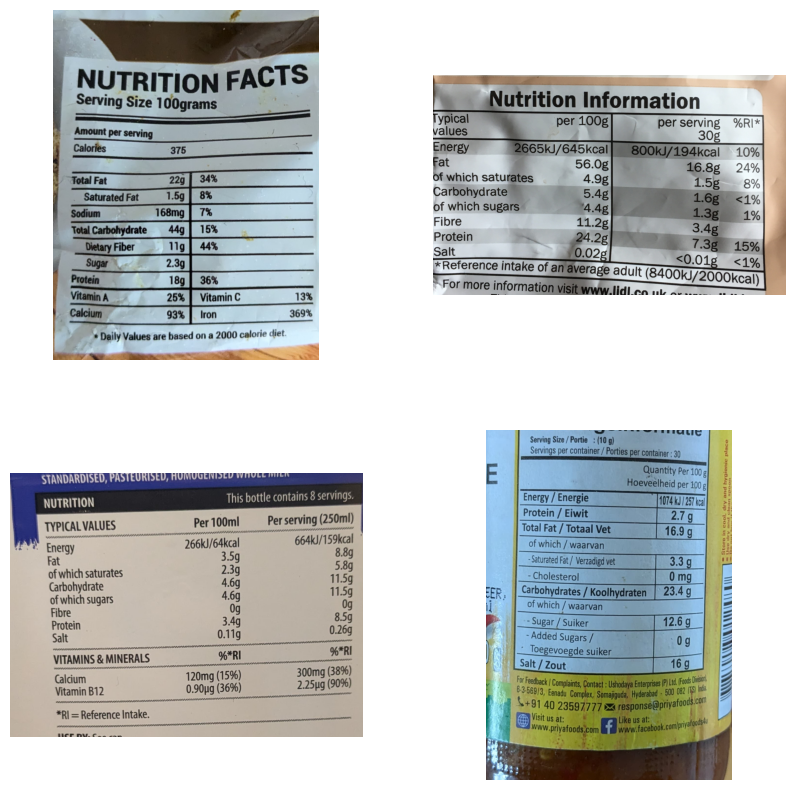

In [30]:
image_cropper.display_cropped_images(cropped_images)

In [31]:
image_cropper.save_cropped_images(cropped_images, 'C:/Users/koust_fiminqv/Desktop/thesis/cropped_images')

In [41]:
import pytesseract
from PIL import Image
import os
import cv2
import numpy as np

In [38]:
pytesseract.pytesseract.tesseract_cmd = r"D://tesseract//tesseract.exe"

In [80]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
    detected_lines = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    removed_lines = cv2.subtract(thresh_image, detected_lines)
    detected_lines = cv2.morphologyEx(removed_lines, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    final_image = cv2.subtract(removed_lines, detected_lines)
    final_image = cv2.bitwise_not(final_image)
    blurred_image = cv2.GaussianBlur(final_image, (5, 5), 0)
    
    return blurred_image

In [81]:
def perform_ocr_on_images(image_paths):
    ocr_results = []
    for image_path in image_paths:
        # Preprocess the image
        preprocessed_image = preprocess_image(image_path)
        
        # Convert the preprocessed image to a format compatible with PIL
        pil_image = Image.fromarray(preprocessed_image)
        
        # Perform OCR with custom configuration
        custom_config = r'--oem 3 --psm 6 -l eng'
        text = pytesseract.image_to_string(pil_image, config=custom_config)
        ocr_results.append((image_path, text))
    return ocr_results

In [82]:
folder_path = 'C:/Users/koust_fiminqv/Desktop/thesis/cropped_images'

In [83]:
paths = []
for i in range(1,5):
  paths.append(folder_path + f'/cropped_image_{i}.png')
paths

['C:/Users/koust_fiminqv/Desktop/thesis/cropped_images/cropped_image_1.png',
 'C:/Users/koust_fiminqv/Desktop/thesis/cropped_images/cropped_image_2.png',
 'C:/Users/koust_fiminqv/Desktop/thesis/cropped_images/cropped_image_3.png',
 'C:/Users/koust_fiminqv/Desktop/thesis/cropped_images/cropped_image_4.png']

In [84]:
ocr_results = perform_ocr_on_images(paths)

In [85]:
for filename, text in ocr_results:
    print(f"Text from {filename}:")
    print(text)
    print("\n" + "="*50 + "\n")

Text from C:/Users/koust_fiminqv/Desktop/thesis/cropped_images/cropped_image_1.png:
= # _
r : — =
‘NUTR TON FACTS
7 Serving Size 100grams _
Calories 375 :
, “Total Fat 22g | 34%
"Saturated Fat ‘1.69 | 8% |

Sodium 168mg | 7% |
"Total Carbohydrate = 44g] 15%

__Dietary Fiber lig] 44% |
1} — Sugar 2.39 |
_ Protein 18g | 36%
Vitamin A 25% | Vitamin C 13%
Calcium 93% | Iron 369%
} * Daily Values are based on a 2000 calorie sfiet



Text from C:/Users/koust_fiminqv/Desktop/thesis/cropped_images/cropped_image_2.png:
| QUITO ome: "on
Typical “SS per 100g perserving %RI*
Energy =365k)/645kcal F_S90ks/194kcal 10% |
Fat 56.0g. 16.8¢ 24%

of which saturates 4.9¢g Sg 8%
Carbohydrate * 5.4g 3 , 166, <1%

of which sugars "44g |) ge? eS ges ch 1%
Fibre 112g 3.45 .
Protein ~ giz \ >@ 7 = 9 |
Salt ¥0.02¢, <0.01 <1% |

7 ; g 6 |
*Reference intake of arverage adult (8400kJ/2000kcal) |

. SSeS Se ee Cal) |

~ For more information , gale mene.) OTS



Text from C:/Users/koust_fiminqv/Desktop/thesis/cropped